# Estimating COVID-19's $R_t$ with Rainier (ported from PYMC)

Grzegorz Kossakowski & Maciek Zdanowicz - May 5 (beta)

Model originally built by [Kevin Systrom](https://twitter.com/kevin) in `Realtime Rt mcmc.ipynb` notebook, ported to [Rainier](https://rainier.fit) with lots of help from [Avi Bryant](https://twitter.com/avibryant). Model comparison for European countries is in `Realtime Rt plots only.ipynb`.

This notebook requires [Almond](https://almond.sh) to run.

It's a work in progress.

In [45]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [46]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [48]:
PPrint.register(repl)

In [49]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

In [50]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [51]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-06",
    "Onset" -> "1.1764563693497703"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-07",
    "Onset" -> "1.2327773749093547"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-08",
    "Onset" -> "1.6886632825719121"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-09",
    "Onset" -> "1.989364273628233"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-10",
    "Onset" -> "2.6221899927483685"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-11",
    "Onset" -> "2.833454193860285"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-12",
    "Onset" -> "3.0132946579647086"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-13",
...

In [52]:
import java.time.LocalDate
import java.time.chrono.ChronoLocalDate
// so comparisons work like max()
import scala.math.Ordering.Implicits._

def toDate(s: String): LocalDate =
    LocalDate.parse(s)

// we need to specify type parameter ChronoLocalDate (a super type of LocalDate) because
// that's what the comparison is defined for
countriesOnsetData.map(entry => toDate(entry("date"))).max[ChronoLocalDate]

import java.time.LocalDate

import java.time.chrono.ChronoLocalDate
// so comparisons work like max()

import scala.math.Ordering.Implicits._


defined function toDate
res51_4: LocalDate = 2020-05-24

In [53]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.007009910563210055"),
  Map("index" -> "1", "pdelay" -> "0.04205946337926034"),
  Map("index" -> "2", "pdelay" -> "0.05801305293691081"),
  Map("index" -> "3", "pdelay" -> "0.07034082668600435"),
  Map("index" -> "4", "pdelay" -> "0.07154943195552332"),
  Map("index" -> "5", "pdelay" -> "0.08581097413584723"),
  Map("index" -> "6", "pdelay" -> "0.07928450568044476"),
  Map("index" -> "7", "pdelay" -> "0.07493352671017646"),
  Map("index" -> "8", "pdelay" -> "0.07686729514140682"),
  Map("index" -> "9", "pdelay" -> "0.07904278462654098"),
  Map("index" -> "10", "pdelay" -> "0.0628474740149867"),
  Map("index" -> "11", "pdelay" -> "0.05148658448150834"),
  Map("index" -> "12", "pdelay" -> "0.04471839497220208"),
  Map("index" -> "13", "pdelay" -> "0.03843364757070341"),
  Map("index" -> "14", "pdelay" -> "0.028764805414551606"),
  Map("index" -> "15", "pdelay" -> "0.026347594875513657"),
  Map("index" -> "

In [54]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }

pdelay: List[Double] = List(
  0.007009910563210055,
  0.04205946337926034,
  0.05801305293691081,
  0.07034082668600435,
  0.07154943195552332,
  0.08581097413584723,
  0.07928450568044476,
  0.07493352671017646,
  0.07686729514140682,
  0.07904278462654098,
  0.0628474740149867,
  0.05148658448150834,
  0.04471839497220208,
  0.03843364757070341,
  0.028764805414551606,
  0.026347594875513657,
  0.019095963258399806,
  0.020546289581822575,
  0.011844331641285956,
  0.009427121102248005,
  0.0096688421561518,
  0.006526468455402465,
  0.004109257916364515,
  0.0036258158085569255,
  0.0029006526468455403,
  0.0036258158085569255,
  0.0019337684312303602,
  4.8344210780759005E-4,
  4.8344210780759005E-4,
  0.0,
  9.668842156151801E-4,
  2.4172105390379503E-4,
  4.8344210780759005E-4,
  7.251631617113851E-4,
  0.0014503263234227702,
  2.4172105390379503E-4,
  4.8344210780759005E-4,
  7.251631617113851E-4,
...

In [55]:
def prepareDataForModel(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    // ensure that case numbers are always at least 1 so we avoid numerical issues involving 0
    // adding 1 across all counts doesn't change inputs in any material way
    // see the comment of `predictRt` method for the rationale
    xs.zip(cpdPadded)
}

defined function prepareDataForModel

Preparation of the other model

In [56]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 1000
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd55$Helper$$anon$1@22c80771

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [57]:
def retry[T](maxAttempts: Int, isSuccessful: T => Boolean)(f: => T): T = {
    var i = 0
    
    do {
        val res = f
        i = i + 1
        if (isSuccessful(res))
            return res
        println(s"WARN: Attempt[$i] failed. Retrying...")
    } while (i < maxAttempts)
    sys.error("Exceeded maximum number of retries")
}

defined function retry

Fixed the parameters for all distributions

In [58]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [59]:
def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts) =  {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(46.0,10.0).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
            Poisson(lambda)
        }
        (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRtOnsetLogProcess

In [60]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb up to different handling of this line
// mu = pm.math.maximum(.1, expected_today)
// my is the lambda of Poisson distribution that must be > 0.
// Kevin's solution is to take max(0.1, expected_today) to ensure
// that lambda > 0. However, `expected_today` is dependent only on input data and is not
// part of the model so we can ensure it's > 0 by fixing up the input data of the model.
// this is done in `prepareDataForModel`
def predictRt(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): RtModelEstimates = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(46.0,1/10.0).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest * cpd * (ThetaT(i).exp)
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        !failedRunDetection || trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
}

defined function predictRt

In [61]:
case class RtsDistributionStats(means: Seq[(Int, Double)], hdpis: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i))))}
    RtsDistributionStats(means, hdpis)
}

defined class RtsDistributionStats
defined function distributionStats

In [26]:
{{
    val countryName = "Italy"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates,_, _) = time { 
        val res = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
        res
    }
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
}}

Chain 1 Complete : Iteration: 1000 (50ms) Acceptance rate: 0.00 E-BFMI: 1.90 Step size: 0.004 Total gradient evaluations: 2e+05 (252us) Total time: 0: 1:29

Chain 2 Warmup : Iteration: 330 (66ms) Acceptance rate: 0.79 E-BFMI: 0.11 Step size: 0.004 Total gradient evaluations: 7e+04 (517us) Total time: 23s

In [62]:
val countriesToPredict = countriesOnsetData.map(_("country")).toSet //smaller set: Seq("Poland", "France", "Italy", "Germany", "Czechia")

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [63]:
import scala.util.Try

val countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
               val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = predictRt(caseNumbers, pdelay, failedRunDetection = false)
               val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
               println(s"$countryName [done]")
               stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (139us) Total time: 0: 1:35

Chain 1 Complete : Iteration: 1000 (76ms) Acceptance rate: 0.85 E-BFMI: 0.73 Step size: 0.01 Total gradient evaluations: 2e+05 (365us) Total time: 0: 3:22

Chain 1 Complete : Iteration: 1000 (75ms) Acceptance rate: 0.88 E-BFMI: 0.54 Step size: 0.01 Total gradient evaluations: 2e+05 (411us) Total time: 0: 3: 4

Chain 1 Complete : Iteration: 1000 (102ms) Acceptance rate: 0.95 E-BFMI: 0.56 Step size: 0.003 Total gradient evaluations: 2e+05 (460us) Total time: 0: 4:21

Chain 2 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (247us) Total time: 0: 1:27

Slovakia [done]


Chain 2 Complete : Iteration: 1000 (126ms) Acceptance rate: 0.86 E-BFMI: 0.75 Step size: 0.01 Total gradient evaluations: 2e+05 (375us) Total time: 0: 3:10

Chain 1 Complete : Iteration: 1000 (124ms) Acceptance rate: 0.79 E-BFMI: 0.73 Step size: 0.03 Total gradient evaluations: 2e+05 (441us) Total time: 0: 2:34

Chain 2 Complete : Iteration: 1000 (81ms) Acceptance rate: 0.78 E-BFMI: 0.60 Step size: 0.01 Total gradient evaluations: 2e+05 (393us) Total time: 0: 3:31

Chain 2 Complete : Iteration: 1000 (97ms) Acceptance rate: 0.84 E-BFMI: 0.74 Step size: 0.004 Total gradient evaluations: 2e+05 (388us) Total time: 0: 4:43

Chain 2 Complete : Iteration: 1000 (69ms) Acceptance rate: 0.74 E-BFMI: 0.73 Step size: 0.03 Total gradient evaluations: 2e+05 (283us) Total time: 0: 2:47

Netherlands [done]


Chain 1 Complete : Iteration: 1000 (34ms) Acceptance rate: 0.83 E-BFMI: 0.80 Step size: 0.03 Total gradient evaluations: 2e+05 (132us) Total time: 0: 1:33

Portugal [done]


Chain 1 Complete : Iteration: 1000 (40ms) Acceptance rate: 0.75 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (121us) Total time: 0: 1:31

Chain 2 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.83 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (189us) Total time: 0: 1:18

Chain 2 Complete : Iteration: 1000 (40ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (108us) Total time: 0: 1:18

Finland [done]


Chain 1 Complete : Iteration: 1000 (44ms) Acceptance rate: 0.79 E-BFMI: 0.59 Step size: 0.01 Total gradient evaluations: 2e+05 (210us) Total time: 0: 1:45

Italy [done]


Chain 1 Complete : Iteration: 1000 (46ms) Acceptance rate: 0.89 E-BFMI: 0.75 Step size: 0.01 Total gradient evaluations: 2e+05 (204us) Total time: 0: 1:58

Bulgaria [done]


Chain 1 Complete : Iteration: 1000 (59ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (361us) Total time: 0: 2:10

Hungary [done]


Chain 1 Complete : Iteration: 1000 (43ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (175us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (53ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.01 Total gradient evaluations: 2e+05 (215us) Total time: 0: 1:54

Chain 2 Complete : Iteration: 1000 (48ms) Acceptance rate: 0.74 E-BFMI: 0.61 Step size: 0.02 Total gradient evaluations: 2e+05 (220us) Total time: 0: 2: 5

Chain 2 Complete : Iteration: 1000 (70ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (295us) Total time: 0: 2:16

Chain 2 Complete : Iteration: 1000 (41ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (161us) Total time: 0: 1:44

Belarus [done]


Chain 1 Complete : Iteration: 1000 (136ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (553us) Total time: 0: 1:49

Cyprus [done]
Ireland [done]


Chain 1 Complete : Iteration: 1000 (84ms) Acceptance rate: 0.89 E-BFMI: 0.69 Step size: 0.006 Total gradient evaluations: 2e+05 (460us) Total time: 0: 4:13

Chain 1 Complete : Iteration: 1000 (41ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (258us) Total time: 0: 2: 7

Norway [done]


Chain 1 Complete : Iteration: 1000 (74ms) Acceptance rate: 0.00 E-BFMI: 1.98 Step size: 0.006 Total gradient evaluations: 2e+05 (599us) Total time: 0: 3:41

Chain 2 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (185us) Total time: 0: 1:58

Chain 2 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (261us) Total time: 0: 1:48

Estonia [done]


Chain 1 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.87 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (187us) Total time: 0: 2: 0

Latvia [done]


Chain 1 Complete : Iteration: 1000 (38ms) Acceptance rate: 0.88 E-BFMI: 0.75 Step size: 0.04 Total gradient evaluations: 2e+05 (840us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (95ms) Acceptance rate: 0.92 E-BFMI: 0.78 Step size: 0.006 Total gradient evaluations: 2e+05 (501us) Total time: 0: 3:27

Chain 2 Complete : Iteration: 1000 (123ms) Acceptance rate: 0.84 E-BFMI: 0.85 Step size: 0.005 Total gradient evaluations: 2e+05 (325us) Total time: 0: 3: 4

Chain 2 Complete : Iteration: 1000 (71ms) Acceptance rate: 0.85 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (373us) Total time: 0: 2: 0

Chain 2 Complete : Iteration: 1000 (35ms) Acceptance rate: 0.83 E-BFMI: 0.74 Step size: 0.04 Total gradient evaluations: 2e+05 (139us) Total time: 0: 1:30

Lithuania [done]


Chain 1 Complete : Iteration: 1000 (48ms) Acceptance rate: 0.85 E-BFMI: 0.61 Step size: 0.01 Total gradient evaluations: 2e+05 (347us) Total time: 0: 2: 0

Czechia [done]


Chain 1 Complete : Iteration: 1000 (43ms) Acceptance rate: 0.87 E-BFMI: 0.63 Step size: 0.02 Total gradient evaluations: 2e+05 (183us) Total time: 0: 1:35

France [done]


Chain 1 Complete : Iteration: 1000 (76ms) Acceptance rate: 0.83 E-BFMI: 0.60 Step size: 0.01 Total gradient evaluations: 2e+05 (266us) Total time: 0: 2:47

Germany [done]


Chain 1 Complete : Iteration: 1000 (150ms) Acceptance rate: 0.79 E-BFMI: 1.82 Step size: 0.0002 Total gradient evaluations: 2e+05 (907us) Total time: 0: 5:20

Chain 2 Complete : Iteration: 1000 (42ms) Acceptance rate: 0.85 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (162us) Total time: 0: 1:44

Chain 2 Complete : Iteration: 1000 (54ms) Acceptance rate: 0.87 E-BFMI: 0.68 Step size: 0.01 Total gradient evaluations: 2e+05 (309us) Total time: 0: 2:12

Chain 2 Complete : Iteration: 1000 (68ms) Acceptance rate: 0.82 E-BFMI: 0.73 Step size: 0.01 Total gradient evaluations: 2e+05 (326us) Total time: 0: 2:45

Romania [done]


Chain 1 Complete : Iteration: 1000 (76ms) Acceptance rate: 0.87 E-BFMI: 0.70 Step size: 0.02 Total gradient evaluations: 2e+05 (485us) Total time: 0: 2:15

Sweden [done]


Chain 1 Complete : Iteration: 1000 (85ms) Acceptance rate: 0.09 E-BFMI: 0.94 Step size: 0.004 Total gradient evaluations: 2e+05 (322us) Total time: 0: 2:57

Chain 2 Complete : Iteration: 1000 (59ms) Acceptance rate: 0.85 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (227us) Total time: 0: 2:22

Switzerland [done]


Chain 2 Complete : Iteration: 1000 (172ms) Acceptance rate: 0.94 E-BFMI: 0.75 Step size: 0.004 Total gradient evaluations: 2e+05 (597us) Total time: 0: 5:36

Chain 1 Complete : Iteration: 1000 (56ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (524us) Total time: 0: 2: 1

Chain 2 Complete : Iteration: 1000 (90ms) Acceptance rate: 0.76 E-BFMI: 0.74 Step size: 0.004 Total gradient evaluations: 2e+05 (359us) Total time: 0: 2:52

Denmark [done]


Chain 1 Complete : Iteration: 1000 (62ms) Acceptance rate: 0.73 E-BFMI: 0.76 Step size: 0.01 Total gradient evaluations: 2e+05 (252us) Total time: 0: 2:28

Chain 2 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (222us) Total time: 0: 1:54

United_Kingdom [done]


Chain 1 Complete : Iteration: 1000 (61ms) Acceptance rate: 0.84 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (332us) Total time: 0: 2:28

Luxembourg [done]


Chain 1 Complete : Iteration: 1000 (50ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (210us) Total time: 0: 1:59

Chain 2 Complete : Iteration: 1000 (55ms) Acceptance rate: 0.00 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (281us) Total time: 0: 2:26

Spain [done]


Chain 1 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.90 E-BFMI: 0.54 Step size: 0.003 Total gradient evaluations: 2e+05 (341us) Total time: 0: 2: 2

Chain 2 Complete : Iteration: 1000 (42ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (208us) Total time: 0: 1:30

Chain 2 Complete : Iteration: 1000 (54ms) Acceptance rate: 0.85 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (331us) Total time: 0: 1:51

Belgium [done]


Chain 1 Complete : Iteration: 1000 (43ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (216us) Total time: 0: 1:32

Greece [done]


Chain 1 Complete : Iteration: 1000 (46ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (218us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.59 E-BFMI: 0.70 Step size: 0.004 Total gradient evaluations: 2e+05 (184us) Total time: 0: 1:53

Austria [done]


Chain 1 Complete : Iteration: 1000 (40ms) Acceptance rate: 0.78 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (152us) Total time: 0: 1:25

Chain 2 Complete : Iteration: 1000 (35ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (167us) Total time: 0: 1:30

Chain 2 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (152us) Total time: 0: 1:22

Russia [done]


Chain 2 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.84 E-BFMI: 0.76 Step size: 0.02 Total gradient evaluations: 2e+05 (97us) Total time: 59s

Slovenia [done]


Chain 1 Complete : Iteration: 1000 (20ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (124us) Total time: 49s

Croatia [done]
Poland [done]


Chain 2 Complete : Iteration: 1000 (16ms) Acceptance rate: 0.00 E-BFMI: NaN Step size: 0 Total gradient evaluations: 2e+05 (100us) Total time: 33s

Malta [done]
Elapsed time: 2278430 ms


import scala.util.Try


countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.5130648295050209),
        (1, 1.5138740445696939),
        (2, 1.5147950070497334),
        (3, 1.5162382944079187),
        (4, 1.5184037747765835),
        (5, 1.5194547527471798),
        (6, 1.5232888926223207),
        (7, 1.5230058121392074),
        (8, 1.526537519067655),
        (9, 1.5262341130959989),
        (10, 1.5293153084673459),
        (11, 1.5248555829696075),
        (12, 1.5269890043773866),
        (13, 1.5234850882005262),
        (14, 1.5171558563676368),
        (15, 1.5167207710723534),
        (16, 1.5123008534296891),
        (17, 1.5119820527365955),
        (18, 1.5073303569761674),
        (19, 1.5013303532492341),
        (20, 1.4934622666643884),
        (21, 1.489772034572469),
        (22, 1.483410543278992),
        (23, 1.4763524509203474),
        (24, 1.4657507223844581),
    

In [71]:
val failedToConverge = countryStats collect {
    case (countryName, res) if res.isLeft => countryName
}

cmd71.sc:2: value isLeft is not a member of ammonite.$sess.cmd62.wrapper.cmd60.RtsDistributionStats
    case (countryName, res) if res.isLeft => countryName
                                   ^Compilation Failed

: 

In [71]:
// co
val countriesTriedOneMoreTime = failedToConverge.toSeq map { countryName =>
    println(countryName)
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val res = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
        res
    }
    countryName -> distributionStats(rts, estimates)
}

countriesTriedOneMoreTime: Seq[(String, RtsDistributionStats)] = List()

In [70]:
val finalCountryStats = (countryStats collect {
    case (countryName, Right(stats)) => countryName -> stats
})// ++ countriesTriedOneMoreTime

cmd70.sc:2: constructor cannot be instantiated to expected type;
 found   : scala.util.Right[A,B]
 required: ammonite.$sess.cmd62.wrapper.cmd60.RtsDistributionStats
    case (countryName, Right(stats)) => countryName -> stats
                       ^Compilation Failed

: 

In [72]:
// override the previous variable so the rest of the notebook works fine
val countryStats = finalCountryStats

countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.5130648295050209),
      (1, 1.5138740445696939),
      (2, 1.5147950070497334),
      (3, 1.5162382944079187),
      (4, 1.5184037747765835),
      (5, 1.5194547527471798),
      (6, 1.5232888926223207),
      (7, 1.5230058121392074),
      (8, 1.526537519067655),
      (9, 1.5262341130959989),
      (10, 1.5293153084673459),
      (11, 1.5248555829696075),
      (12, 1.5269890043773866),
      (13, 1.5234850882005262),
      (14, 1.5171558563676368),
      (15, 1.5167207710723534),
      (16, 1.5123008534296891),
      (17, 1.5119820527365955),
      (18, 1.5073303569761674),
      (19, 1.5013303532492341),
      (20, 1.4934622666643884),
      (21, 1.489772034572469),
      (22, 1.483410543278992),
      (23, 1.4763524509203474),
      (24, 1.4657507223844581),
      (25, 1.4510871824739768),
      (26, 1.4390370664538596),
      (27, 1.4250348097868533),
      (28, 1.4

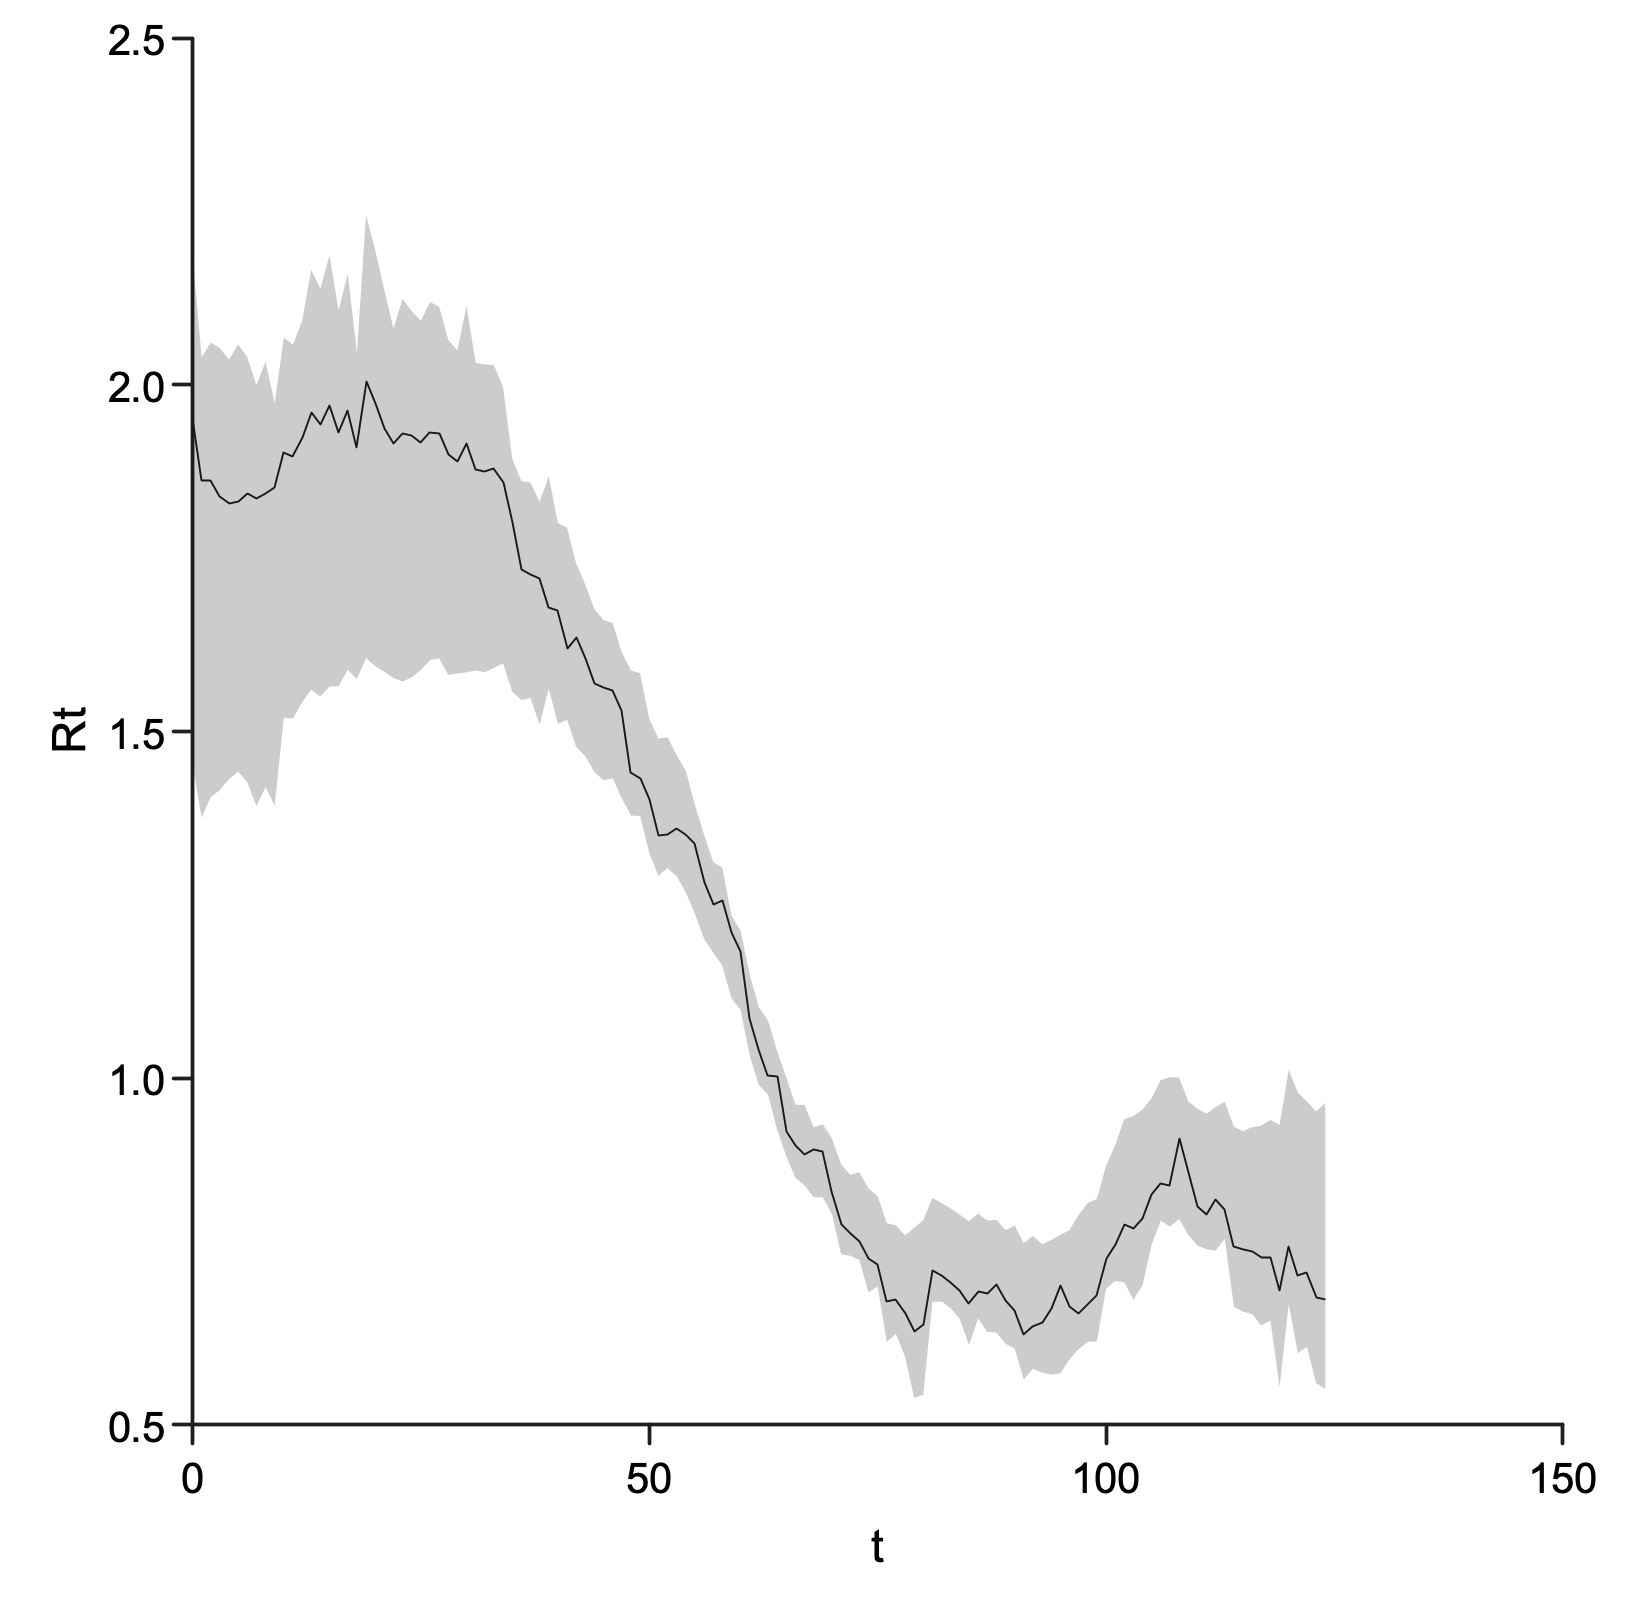

In [87]:
{{
    val RtsDistributionStats(means, hdpis) = countryStats("France")
    //  val RtsDistributionStats(means, hdpis) = countryStats("Austria")
    show("t", "Rt", line(means), shade(hdpis))
}}

In [77]:
def datesForCountry(country: String) = {
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [78]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val xs = stats.means.unzip._2 zip stats.hdpis.unzip._2
    val dates = datesForCountry(country)
//     assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case ((mean, (low90, high90)), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: low90.toString :: high90.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [79]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@e5e8d9b

In [80]:
csvWriter.writeRow(List("country", "date", "ML", "Low_90", "High_90"))

In [81]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [82]:
csvWriter.close()